In [1]:
import os, glob
import pandas as pd
import numpy as np
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import RFormula
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(font_scale=1.5, rc={'text.usetex' : True})

sc = SparkContext('local')
spark = SparkSession(sc)

path = "./input/clean/training_data/"

In [2]:
NC_data = spark.read.csv(path + "NOAA_NC_DAvg_training_data.csv", header=True, inferSchema=True)
NC_data = NC_data.drop(*[t for t in NC_data.columns if t[-1] == 'T']+['date','CLASS'])
NC_data.show(5)

+------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+------------------+------------------+------------------+
|             ATemp|           MaxTemp|           MinTemp|               RH|            MaxRH|            MinRH|                BP|             MaxBP|             MinBP|              WSpd|              Wdir|            SDWDir|           MaxWSpd|            MinWSpd|             TotPrcp|            TotPAR|           AvgVolt|              Temp|
+------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------------------+------------------+-------

In [5]:
# vector of features
rf = RFormula(formula="Temp~.")
vector_rf = rf.fit(NC_data).transform(NC_data).select(["features","label"])
vector_rf.show(5)

+--------------------+------------------+
|            features|             label|
+--------------------+------------------+
|[8.29687499999999...|10.641145833333328|
|[11.0645833333333...|11.089062499999999|
|[15.5343749999999...|12.167708333333321|
|[19.1302083333333...|13.960937499999993|
|[19.6677083333333...|15.548437499999999|
+--------------------+------------------+
only showing top 5 rows



In [6]:
train,test = vector_rf.randomSplit([0.80,0.20],42069)

In [7]:
# Train a RandomForest model.
rf = RandomForestRegressor(featuresCol="features", maxDepth = 10, numTrees = 100)

# Train model.  This also runs the indexer.
model = rf.fit(train)

# Make predictions.
predictions = model.transform(test)

# Select example rows to display.
predictions.select("prediction", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

+------------------+------------------+--------------------+
|        prediction|             label|            features|
+------------------+------------------+--------------------+
| 6.572828408006164|         4.5515625|[-0.3041666666666...|
|7.0026388460806706|6.6705882352941135|[0.91458333333333...|
| 6.546577109550251| 5.864583333333335|[1.20937500000000...|
| 7.297839495725986| 6.894791666666664|[1.87105263157894...|
|7.4188454111650755| 4.579166666666668|[2.24687499999999...|
+------------------+------------------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 1.80334


In [8]:
def cartesian_grid(depth, treen):

    depth_range = np.arange(1, depth, 2)

    treen_range = np.arange(1, treen, 10)

    return [(a, b) for a in depth_range for b in treen_range]

In [9]:
rf_rmse = []
grid = cartesian_grid(15,200)
for value in grid:
    rf = RandomForestRegressor(featuresCol="features", maxDepth = value[0], numTrees = value[1])
    model = rf.fit(train)
    predictions = model.transform(test)
    evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
    rf_rmse.append(evaluator.evaluate(predictions))

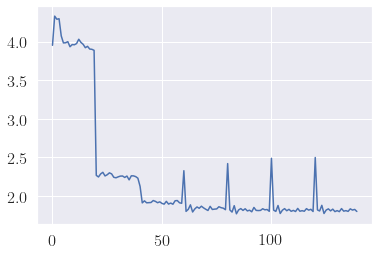

In [10]:
sns.lineplot(range(0,140), rf_rmse)

In [ ]:
grid[45]

In [ ]:
rf = RandomForestRegressor(featuresCol="features", maxDepth = 5, numTrees = 50)
model = rf.fit(train)
predictions = model.transform(test)
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator.evaluate(predictions)